## Traffic Sign Classifier using Deep Learning

The goal of the project is to classify Traffic signs using Convolutional Network and TensorFlow. The data set we will use is the German Traffic Sign data set that can be dowloaded from [here](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset#Downloads).
german Trafffic Sign Dataset is a set of 51,839 labeled images of 43 different German traffic signs. It comes in two separate sets. A set of 39,209 images for training and another set of 12,630 in order to test the accuracy of our trained network.
A pickled version of the dataset can be downloaded from [here](https://d17h27t6h515a5.cloudfront.net/topher/2016/November/581faac4_traffic-signs-data/traffic-signs-data.zip). We will use this dataset instead

### Load the DataSet

In [1]:
import pickle

training_file = 'train.p'
test_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(test_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

As we see the total number of training examples is 39209 and testing examples is 12630. The total number of classes i.e. the different categories of the images are 43 and each image is a RGB image of size 32x32

In [2]:
n_train = len(X_train)
n_test = len(X_test)

image_shape = X_train[0].shape
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Data Visualization

Visualize some of the images that we have in the dataset. Also let us see the distribution of images in the different classes in the training and test set.

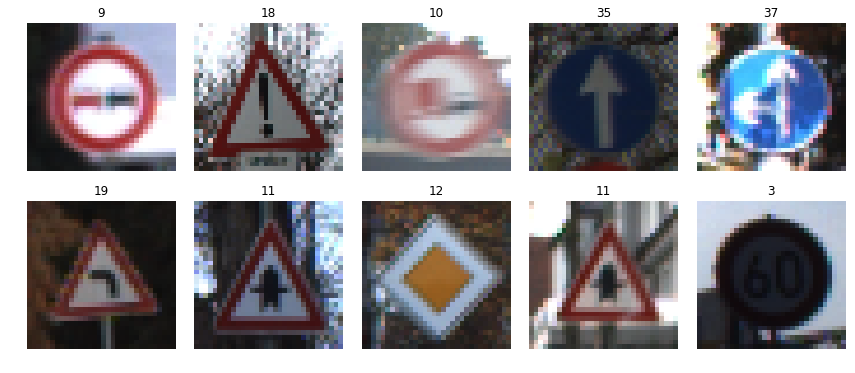

In [3]:
import matplotlib.pyplot as plt
import random

%matplotlib inline

# show image of 10 random data points
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])

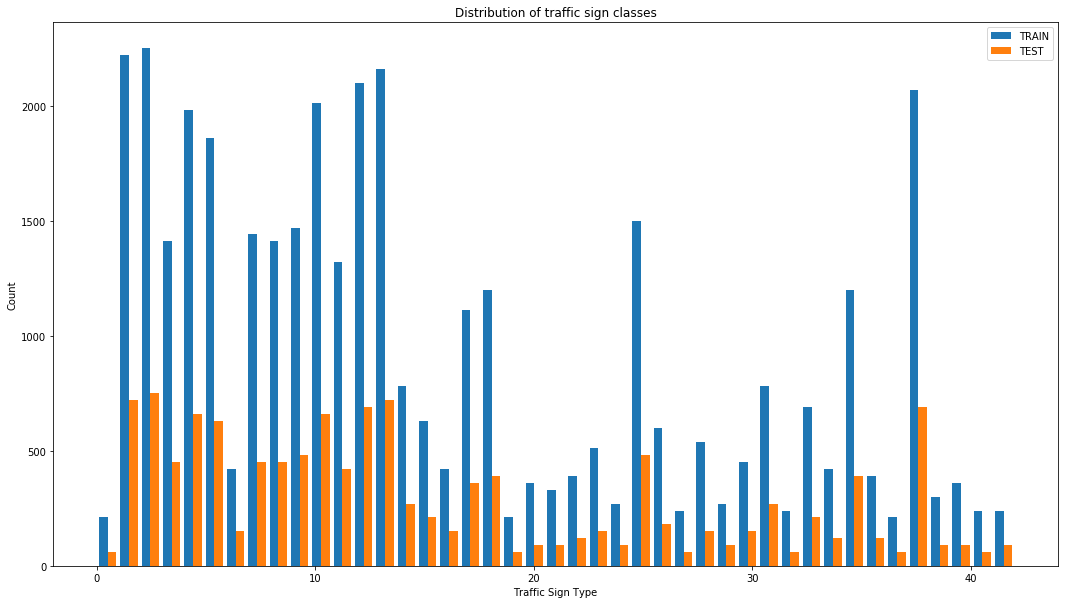

In [4]:
plt.figure(figsize=(18,10))
bins = 43
plt.title("Distribution of traffic sign classes")
plt.hist([y_train,y_test], bins, stacked=False, 
         label=['TRAIN','TEST'])
plt.xlabel("Traffic Sign Type")
plt.ylabel('Count')
plt.legend()
plt.show()

I decided to convert the images to grayscale because the classifier performs better working with only one parameter. 
As a last step, I normalize the image data because to avoid gradient oscillation and to converge faster while training.

In [5]:
import cv2
from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle
from skimage.color import rgb2gray
import numpy as np

def normalize(img):
    return cv2.normalize(img, img, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

def grayscale(img):
    return rgb2gray(img)

def setgrayscale(images):
    print(images.shape)
    result = np.zeros(shape=(len(images),32,32))
    for i in range(len(images)): 
        gray_img = grayscale(images[i])
        img_normalized = normalize(gray_img)
        result[i] = img_normalized
    print(result.shape)
    return result

(39209, 32, 32, 3)
(39209, 32, 32)
(12630, 32, 32, 3)
(12630, 32, 32)


(-0.5, 31.5, 31.5, -0.5)

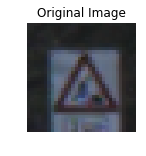

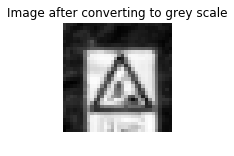

In [6]:
X_traingray = setgrayscale(X_train)
X_testgray = setgrayscale(X_test)

index = random.randint(0, len(X_traingray))

image = X_train[index]
plt.figure(figsize=(2,2))
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

image = X_traingray[index]
plt.figure(figsize=(2,2))
plt.imshow(image,cmap="Greys_r")
plt.title('Image after converting to grey scale')
plt.axis('off')

The data is divided into training set and validation set, which is generated by train_test_split function of sklearn, where the training set is 80% and the verification set is 20%. To cross validate my model, I randomly split the training data into training set and validation set. I did this by using train_test_split function that split the input sets in random subsets with size 80/20 of the input.

My final training set had 31367 number of images. My validation set and test set had 7842 and 12630 number of images.

In [7]:
X_traingray, X_validationgray, y_train, y_validation = train_test_split(X_traingray, y_train, test_size=0.2, random_state=0)

X_traingray, y_train = shuffle(X_traingray, y_train)
print(X_traingray.shape)
print(X_validationgray.shape)
print(y_train.shape)
print(y_validation.shape)

(31367, 32, 32)
(7842, 32, 32)
(31367,)
(7842,)


To train this model, I have used an instance on Google Cloud Platform with 1 NVIDIA Tesla K80 GPU. The reason why I went for GCP and not AWS is GCP provides a credit of $300 while signing in for 1 year which is quite cool. To know more about how to create an instance in GCP check out this [link](http://cs231n.github.io/gce-tutorial/). Once you have your instance ready you will have install CUDA 9.0 and CuDNN 7.04 for TensorFlow 1.6. Make sure that you check the version of CUDA and CuDNN for the tensorflow version that you are installing. Check out this [link](https://towardsdatascience.com/how-to-traine-tensorflow-models-79426dabd304) for detailed steps.

In [8]:
import warnings
import tensorflow as tf

print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train the model.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.6.0
Default GPU Device: /device:GPU:0


### Training the Model

Train the model for 30 epochs with a batch size of 128

In [9]:
from tensorflow.contrib.layers import flatten

EPOCHS = 30
BATCH_SIZE = 128

# tf Graph input
x = tf.placeholder(tf.float32,(None, 32, 32))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)
one_hot_y = tf.one_hot(y,43)

The Convolutinal architecture that we will use is the LeNet architecture.  
First Layer is a CNN with a filter size of 5 and strides of 1  
Then we will apply max pooling with fiter size of 2  
Second Layer will be another CNN with filter sixe of 5 and strides of 1 with VALID padding  
Then we will apply max pooling  
Third layer will be fully connected layer with 120 outputs  
Fourth layer will be another fully connected layer with 84 outputs  
Fifth and the layer will be a fully connected layer with 43 outputs equal to the number of classes.

In [10]:
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.075
    
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 32, 32, 1])
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #  Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    #  Activation.
    conv2 = tf.nn.relu(conv2)

    #  Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #  Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    #  Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    #  Activation.
    fc1    = tf.nn.relu(fc1)

    #  Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    #  Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Apply Dropout
    #fc2 = tf.nn.dropout(fc2, keep_prob) # Apply Dropout

    #  Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))    
    logits = tf.matmul(fc2, fc3_W) + fc3_b
 
    return logits

I used the Adam optimizer with learning rate of 0.01 and default parameters as it is currently regarded as the most efficient.

In [11]:
rate = 0.01

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### Calculate and report the accuracy on the training and validation set.
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: .8})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [12]:
val_accuracy = []
train_accuracy = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_traingray)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_traingray, y_train = shuffle(X_traingray, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_traingray[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: .8})
            
        validation_accuracy = evaluate(X_validationgray, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        training_accuracy = evaluate(X_traingray, y_train)
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print()
        val_accuracy.append(validation_accuracy)
        train_accuracy.append(training_accuracy)
        
    saver.save(sess, './lenet')
    print("Model saved") 

Training...

EPOCH 1 ...
Validation Accuracy = 0.790
Training Accuracy = 0.802

EPOCH 2 ...
Validation Accuracy = 0.869
Training Accuracy = 0.878

EPOCH 3 ...
Validation Accuracy = 0.947
Training Accuracy = 0.964

EPOCH 4 ...
Validation Accuracy = 0.956
Training Accuracy = 0.968

EPOCH 5 ...
Validation Accuracy = 0.948
Training Accuracy = 0.967

EPOCH 6 ...
Validation Accuracy = 0.950
Training Accuracy = 0.967

EPOCH 7 ...
Validation Accuracy = 0.960
Training Accuracy = 0.977

EPOCH 8 ...
Validation Accuracy = 0.948
Training Accuracy = 0.959

EPOCH 9 ...
Validation Accuracy = 0.957
Training Accuracy = 0.973

EPOCH 10 ...
Validation Accuracy = 0.963
Training Accuracy = 0.978

EPOCH 11 ...
Validation Accuracy = 0.936
Training Accuracy = 0.952

EPOCH 12 ...
Validation Accuracy = 0.955
Training Accuracy = 0.972

EPOCH 13 ...
Validation Accuracy = 0.970
Training Accuracy = 0.984

EPOCH 14 ...
Validation Accuracy = 0.934
Training Accuracy = 0.951

EPOCH 15 ...
Validation Accuracy = 0.963
Tra

Validation accuracy of 96.4% is quite good. Lets plot the trend of the accuracy values on the training and validation set

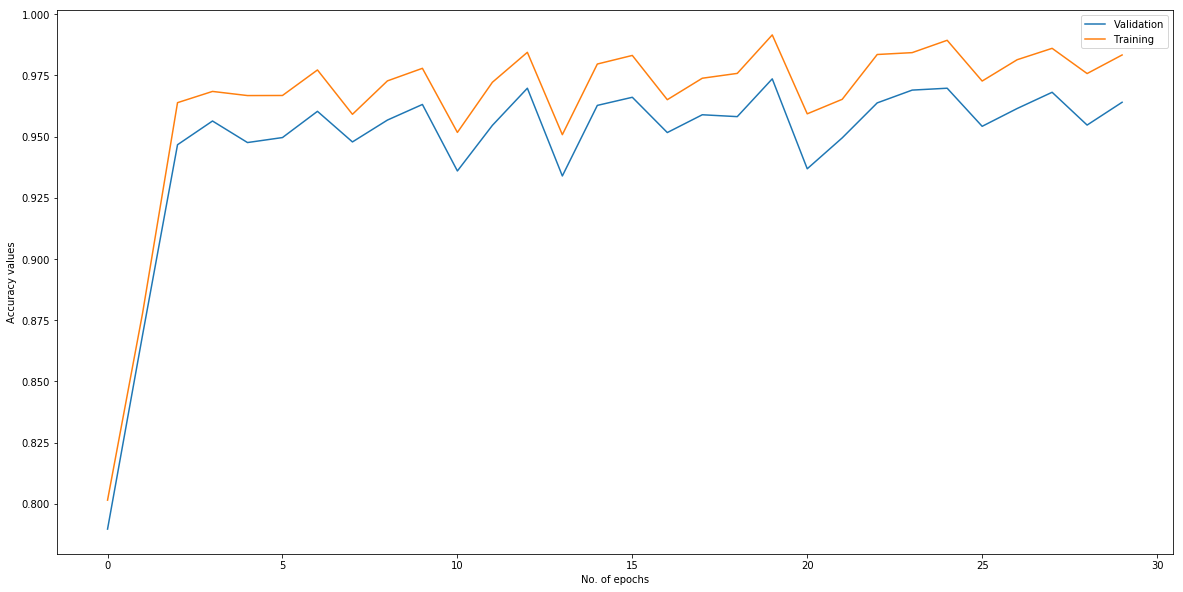

In [13]:
plt.figure(figsize=(20,10))
line_one, = plt.plot(val_accuracy, label='Validation')
line_two, = plt.plot(train_accuracy, label = 'Training')
plt.ylabel('Accuracy values')
plt.xlabel('No. of epochs')
plt.legend(handles=[line_one, line_two])

In [14]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_testgray, y_test)
    
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.918


We obtain a test acccuracy of 91.8% which is good.  
We can further improve this model by using different techniques like 
* Increasing the number of Convolutional Layers
* Using a different architecture like VGG, AlexNet, ResNet etc
* Use Data Augmentation techniques to increase the number of images that we have for training